In [29]:


import numpy as np #
import pandas as pd # 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/supermarket-dataset/().xlsx


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## Data Loading and Exploration

In [31]:

df = pd.read_excel('/kaggle/input/supermarket-dataset/().xlsx')


print("Dataset bilgi:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nilk 5 kişi:")
print(df.head())

Dataset bilgi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Category           9994 non-null   object        
 1   City               9994 non-null   object        
 2   Country            9994 non-null   object        
 3   Customer Name      9994 non-null   object        
 4   Manufacturer       9994 non-null   object        
 5   Order Date         9994 non-null   datetime64[ns]
 6   Order ID           9994 non-null   object        
 7   Postal Code        9994 non-null   int64         
 8   Product Name       9994 non-null   object        
 9   Region             9994 non-null   object        
 10  Segment            9994 non-null   object        
 11  Ship Date          9994 non-null   datetime64[ns]
 12  Ship Mode          9994 non-null   object        
 13  State              9994 non-null   object       

## Feature Engineering || Öznitelik çıkarımı

In [32]:
# Kar ve Satış sütunlarını sayısal olduklarından emin olmak için temizleyin
# Dolar işaretlerini kaldırın ve float'a dönüştürün
df['Sales'] = df['Sales'].replace(r'[\$,]', '', regex=True).astype(float)# sales satış yani float türüne çevrilmiş
df['Profit'] = df['Profit'].replace(r'[\$,]', '', regex=True).astype(float)#kar satış yani float türüne çevrilmiş

In [33]:
# Yeni özellikler oluşturun: Güncellik (son siparişten bu yana geçen gün sayısı), Sıklık (müşteri başına sipariş sayısı), Parasal (müşteri başına toplam satış)
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
latest_date = df['Order Date'].max() # en geç tarihi bulur burdaki ona göre 
print("\nLatest Order Date:", latest_date)


Latest Order Date: 2016-12-30 00:00:00


In [34]:
#genellikle RFM analizinin ilk ayağıdır.
# recency güncellik demek yani son siparişten  geçen gün
#"Recency" (Türkçesiyle *"Güncellik" ya da "Son Siparişten Geçen Gün") müşterinin ne kadar yakın zamanda sipariş verdiğini ölçer.

#Daha düşük Recency değeri → müşteri daha yakın zamanda sipariş vermiştir.

#Daha yüksek Recency değeri → müşteri uzun süredir sipariş vermemiştir.

#Bu metrik, müşteri sadakatini ve geri kazanım stratejilerini analiz etmekte kullanılır.
#Örneğin, çok eski sipariş tarihi olan müşterilere hatırlatma e-postaları göndermek gibi.

df['Recency'] = (latest_date - df['Order Date']).dt.days
print("\nDataFrame güncellik bölümü (ilk 5):") # ilk 5 satır
print(df[['Customer Name', 'Order Date', 'Recency']].head())


DataFrame güncellik bölümü (ilk 5):
   Customer Name Order Date  Recency
0  Darren Powers 2013-01-03     1457
1  Phillina Ober 2013-01-04     1456
2  Phillina Ober 2013-01-04     1456
3  Phillina Ober 2013-01-04     1456
4     Mick Brown 2013-01-05     1455


In [35]:
# Müşteri düzeyindeki özellikleri bir araya getirmek
#burda müsteriyi tek bir satırdA BİLGİLERİ TOPLAMAK İCİN

                     

customer_agg = df.groupby('Customer Name').agg({
    'Order ID': 'count',  # kaç adet aldığı sıklığı verir bize
    'Sales': 'sum',       # toplam satın alımı
    'Recency': 'min'      # En son satın alma , yani iki sipariş arasındaki süresinin minimumu ne sıklıkla yaptığı anlayabiliriz
}).rename(columns={'Order ID': 'Frequency', 'Sales': 'Monetary'})
customer_agg.reset_index(inplace=True)
print("\nMüşteriye Ait Toplanmış Veriler (İlk 5 Satır):")
print(customer_agg.head())


Müşteriye Ait Toplanmış Veriler (İlk 5 Satır):
     Customer Name  Frequency  Monetary  Recency
0    Aaron Bergman          6     887.0      415
1    Aaron Hawkins         11    1744.0       12
2   Aaron Smayling         10    3051.0       88
3  Adam Bellavance         18    7757.0       54
4        Adam Hart         20    3251.0       34


In [36]:
# Müşteri bazlı özet metrikleri (customer_agg içinde) alıp, orijinal sipariş verisi (df) ile birleştirerek işlem (satır) bazında zenginleştirme yapılır.
# yani az önceki verileri müşteri tablosuna geri dönüştürerek eklemektir , zenginleştirmeyi sağlar
df = df.merge(customer_agg[['Customer Name', 'Frequency', 'Monetary', 'Recency']], on='Customer Name', how='left', suffixes=('', '_agg')) #suffixes aynı isimde sütün var ise _agg ekler yani recency gibi çünkü biz onu değiştirdik
print("\nBirleştirme Sonrası Veri Çerçevesi (İlk 5 Satır):")
print(df[['Customer Name', 'Recency', 'Recency_agg', 'Frequency', 'Monetary']].head())# burda yeni recency ->recency_agg olarak gözükür suffixes sayesinde


Birleştirme Sonrası Veri Çerçevesi (İlk 5 Satır):
   Customer Name  Recency  Recency_agg  Frequency  Monetary
0  Darren Powers     1457          126         17    1051.0
1  Phillina Ober     1456           86         10    1057.0
2  Phillina Ober     1456           86         10    1057.0
3  Phillina Ober     1456           86         10    1057.0
4     Mick Brown     1455           44         10    1429.0


In [37]:
# Kümeleme için özellikleri seçin
#k- ortalamalar kullanılıcak bu yüzden kümeleme için özellikler seçilicek
features = ['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount']
categorical_features = ['Category', 'Region', 'Sub-Category']


In [38]:
# Kategorik özellikleri kodla
# labelencoder ile işlem hacmini vs vs azaltıcağız
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col + '_Encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    features.append(col + '_Encoded')

In [39]:
# normal dataframi kopyalıyoruz işlemek icin
df_copy = df.copy()

In [40]:
# DataFrame'de özelliklerin mevcut olduğunu doğrulama
print("\nDataFrame'de Mevcut Sütunlar")
print(df.columns.tolist())
print("\nKümeleme için Seçilmiş Özellikler:")
print(features)


DataFrame'de Mevcut Sütunlar
['Category', 'City', 'Country', 'Customer Name', 'Manufacturer', 'Order Date', 'Order ID', 'Postal Code', 'Product Name', 'Region', 'Segment', 'Ship Date', 'Ship Mode', 'State', 'Sub-Category', 'Discount', 'Number of Records', 'Profit', 'Profit Ratio', 'Quantity', 'Sales', 'Recency', 'Frequency', 'Monetary', 'Recency_agg', 'Category_Encoded', 'Region_Encoded', 'Sub-Category_Encoded']

Kümeleme için Seçilmiş Özellikler:
['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount', 'Category_Encoded', 'Region_Encoded', 'Sub-Category_Encoded']


In [41]:
# standartizasyon , normalizasyon vs vs denenebilir
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)

In [42]:
# standartizasyon yaptığımız veriler
print("\nKümeleme için Ölçeklendirilmiş Özellikler:")
print(scaled_df.head())


Kümeleme için Ölçeklendirilmiş Özellikler:
   Recency_agg  Frequency  Monetary  Quantity    Profit  Discount  \
0     0.036936   0.196702 -0.896076 -0.804303 -0.096702  0.212153   
1    -0.221406  -0.855192 -0.893962 -0.354865 -0.105240  0.212153   
2    -0.221406  -0.855192 -0.893962 -0.354865 -0.399805  0.212153   
3    -0.221406  -0.855192 -0.893962 -0.804303 -0.143662  3.118544   
4    -0.492666  -0.855192 -0.762878 -0.354865 -0.100971  0.212153   

   Category_Encoded  Region_Encoded  Sub-Category_Encoded  
0          0.043552       -1.351357              0.872974  
1          0.043552       -1.351357              0.477027  
2          0.043552       -1.351357              1.268921  
3          0.043552       -1.351357             -0.908789  
4          0.043552       -0.490972             -1.106763  


Gözlemler:

Aykırı Değerler: Adam Bellavance'ın (7757) Parasal değeri diğerlerinden çok daha yüksektir (örneğin, Aaron Bergman için 887 $), bu da harcama davranışında olası aykırı değerler olduğunu gösterir burada model davranışı işin iyileştirme gerekebilir .
Yakınlık Değişimi: Aaron Hawkins (12 gün) gibi müşteriler çok yakın zamanda satın alanlar iken, Aaron Bergman (415 gün) daha az aktiftir ve bu da farklı kümeler oluşturabilir.
Kategorik Özellikler: Kodlanmış kategorik özellikler çeşitlilik gösterir (örneğin, -1.351357'ye karşı -0.490972). Bu, kümelemeyi etkileyebilecek bölgesel farklılıkları vurgular.

## Exploratory Data Analysis

In [43]:
# daha iyi görünüm için tablolarda
plt.style.use('seaborn')
sns.set_palette('husl')

In [44]:
# Sayısal özelliklere ilişkin özet istatistikler
print("Sayısal özelliklere ilişkin özet istatistikler:")
print(df[['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount']].describe()) # describe ile bunların istatiksel şekilde verileri gelir mean vs vs 

Sayısal özelliklere ilişkin özet istatistikler:
       Recency_agg    Frequency      Monetary     Quantity       Profit  \
count  9994.000000  9994.000000   9994.000000  9994.000000  9994.000000   
mean    120.281069    15.691015   3593.956274     3.789574    28.651891   
std     154.841098     6.654997   2838.021830     2.225110   234.255712   
min       0.000000     1.000000      5.000000     1.000000 -6600.000000   
25%      28.000000    11.000000   1669.000000     2.000000     2.000000   
50%      60.000000    15.000000   2873.500000     3.000000     9.000000   
75%     146.000000    20.000000   4714.000000     5.000000    29.000000   
max    1165.000000    37.000000  25042.000000    14.000000  8400.000000   

          Discount  
count  9994.000000  
mean      0.156203  
std       0.206452  
min       0.000000  
25%       0.000000  
50%       0.200000  
75%       0.200000  
max       0.800000  


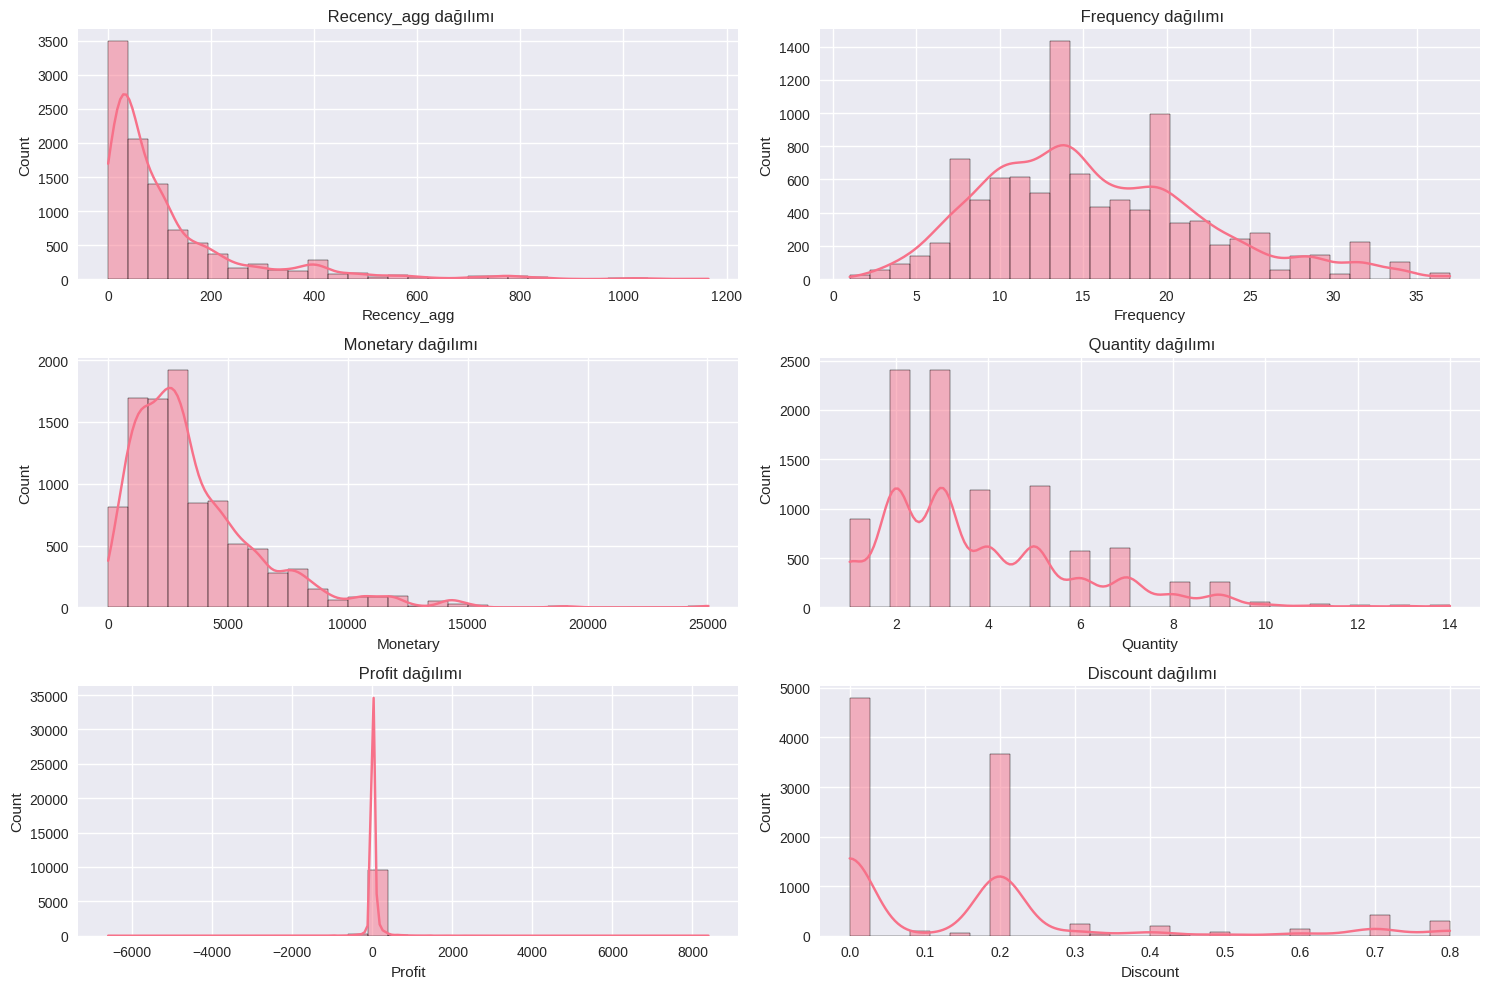

In [45]:
# Sayısal Özelliklerin Dağılımı
numerical_features = ['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f' {feature} dağılımı')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

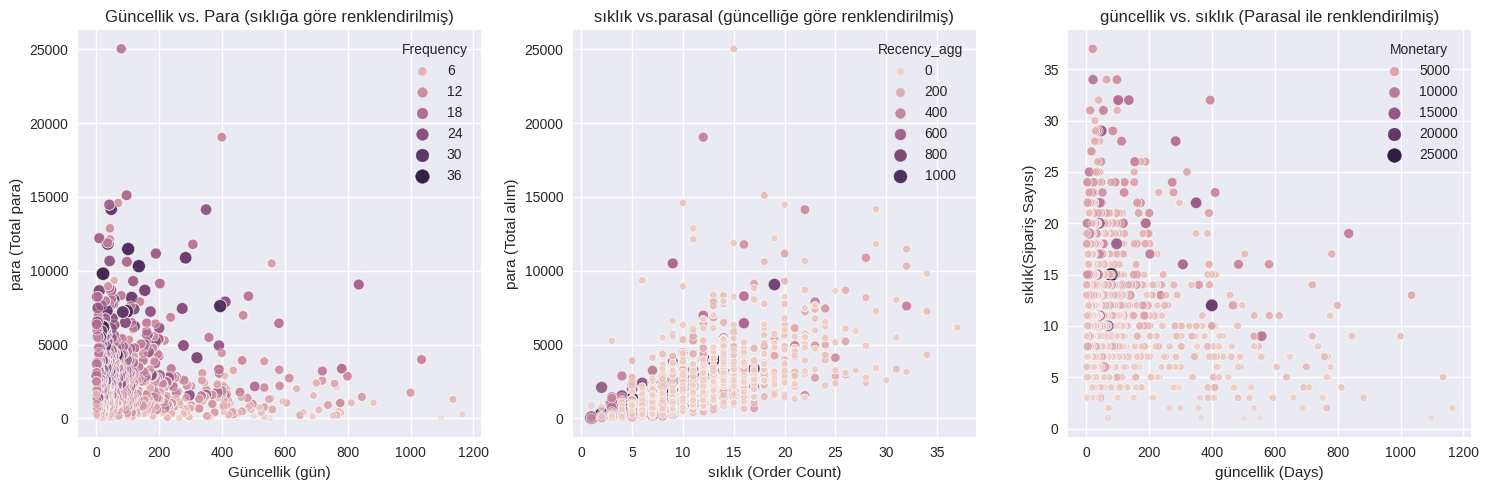

In [46]:
# 2. RFM Özellikleri için sCatter Plotları
plt.figure(figsize=(15, 5))

# Güncellik vs. Para
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='Recency_agg', y='Monetary', hue='Frequency', size='Frequency', alpha=0.6)
plt.title('Güncellik vs. Para (sıklığa göre renklendirilmiş)')
plt.xlabel('Güncellik (gün)')
plt.ylabel('para (Total para)')

# sıklık vs.para
plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='Frequency', y='Monetary', hue='Recency_agg', size='Recency_agg', alpha=0.6)
plt.title('sıklık vs.parasal (güncelliğe göre renklendirilmiş)')
plt.xlabel('sıklık (Order Count)')
plt.ylabel('para (Total alım)')

# güncellik vs. sıklık
plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x='Recency_agg', y='Frequency', hue='Monetary', size='Monetary', alpha=0.6)
plt.title('güncellik vs. sıklık (Parasal ile renklendirilmiş)')
plt.xlabel('güncellik (Days)')
plt.ylabel('sıklık(Sipariş Sayısı)')

plt.tight_layout()
plt.show()

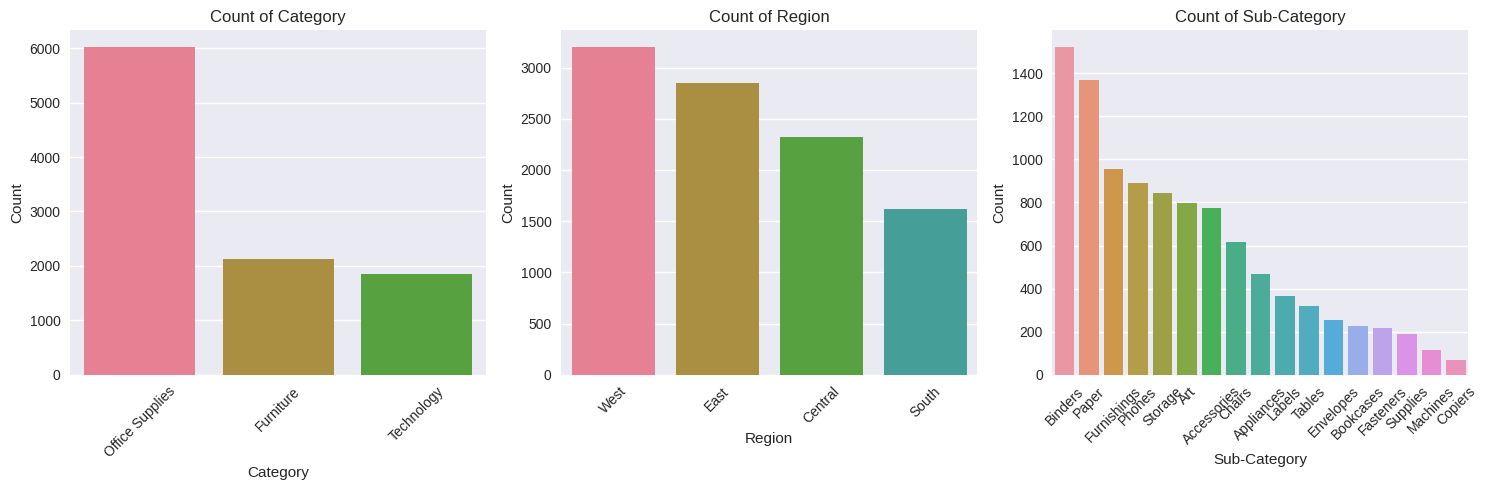

In [47]:
# Kategorik Özellik Analizi
categorical_features = ['Category', 'Region', 'Sub-Category']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)
    plt.title(f'Count of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

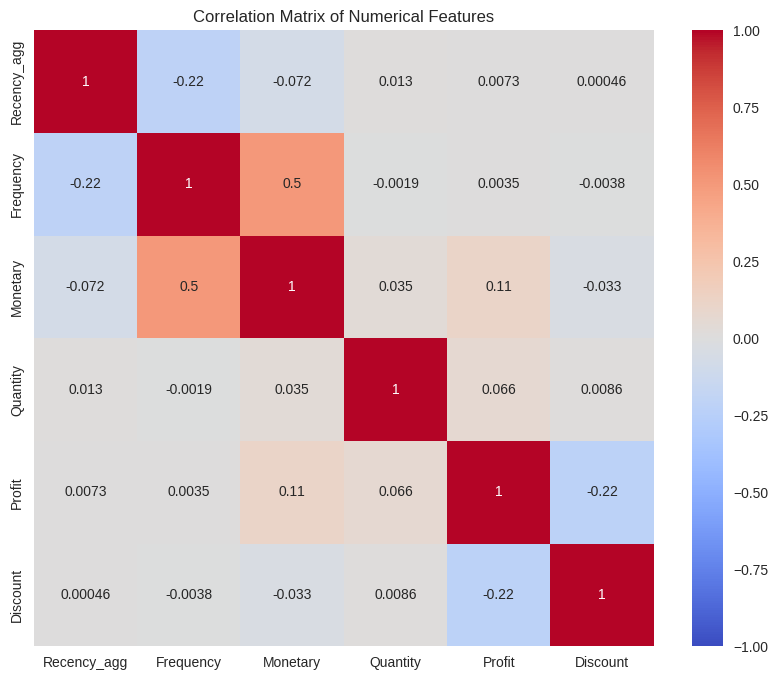

In [32]:
# Sayısal Özellikler için Korelasyon Matrisi  ,anlam çıkarmak için
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Sayısal Özelliklerin Korelasyon Matrisi')
plt.show()

In [49]:
# yukarıda standartizasyon uyguladığımız data var artık bunun üzerinden gideceğizç
X = scaled_df

In [50]:
# Determine optimal number of clusters using elbow method
inertia = [] #Her bir kümedeki noktaların küme merkezine (centroid) olan uzaklıklarının karelerinin toplamını hesaplar.
silhouette_scores = [] #Her bir veri noktasının kendi kümesi içinde ne kadar iyi gruplandığını (-1 ile +1 arasında) puanlar.
# sonra ise 
K = range(2, 11) # k değerleri 2 ile 11 arasında 

for k in K: # her k değeri için dönecek
    kmeans = KMeans(n_clusters=k, random_state=13, n_init=15)#n_init =Algoritmanın farklı başlangıç merkezleriyle kaç kez çalıştırılacağını belirtir.
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

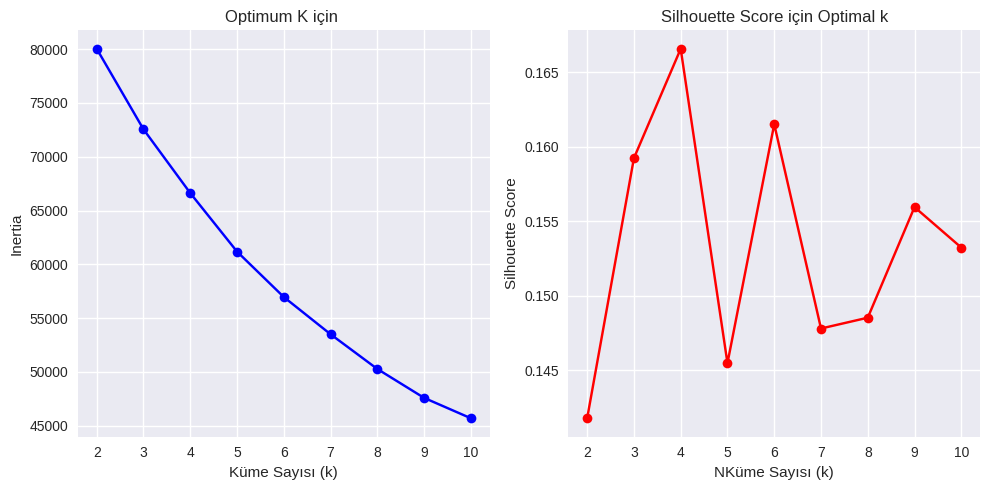

In [51]:
# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Inertia')
plt.title('Optimum K için ')
plt.grid(True)

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('NKüme Sayısı (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score için Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

best k = 4

In [52]:
# Fit K-Means with the optimal k=4
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

In [54]:
# Orijinal veri çerçevesine küme etiketleri ekleyin
df['Cluster'] = cluster_labels # elde edilen küme bilgilerini tutarız

In [55]:
# oluşan sınıfların kaç adet birey bulunduğunu göstermek
print("\nKüme Dağıtımı:")
print(df['Cluster'].value_counts())


Küme Dağıtımı:
Cluster
2    5605
1    2374
0    1085
3     930
Name: count, dtype: int64


In [56]:
# İlk birkaç satırı küme etiketleriyle görüntüle
print("\nKüme Etiketli DataFrame (İlk 5 Satır):")
print(df[['Customer Name', 'Recency_agg', 'Frequency', 'Monetary', 'Cluster']].head())


Küme Etiketli DataFrame (İlk 5 Satır):
   Customer Name  Recency_agg  Frequency  Monetary  Cluster
0  Darren Powers          126         17    1051.0        2
1  Phillina Ober           86         10    1057.0        2
2  Phillina Ober           86         10    1057.0        2
3  Phillina Ober           86         10    1057.0        0
4     Mick Brown           44         10    1429.0        2


In [61]:
# df_copy olan normalize edilmiş datayı başka bir işlemde kullanmak icin kopyalıyoruz
df_tune = df_copy.copy()

aşağıdaki işlemde çarpıklığı (Skewness) Düzeltmek için yapacağız sebebi ise para birimlerinin toplamı sağa çarpık olduğu için uygulamak logoritmik dönüşüm yapmak zorundayız
Problem: Monetary (örneğin müşterilerin toplam harcama tutarı) gibi sütunlar genelde sağa çarpık (right-skewed) dağılıma sahiptir:

Çoğu müşteri düşük harcama yapar, az sayıda müşteri çok yüksek harcama yapar (aykırı değerler).

In [63]:
# çarpıklığı azaltmak para birimindeki
df_tune['Monetary'] = np.log1p(df_tune['Monetary'])  # log1p sıfır değerlerini işler o yüzden log1p kullanıcaz

In [65]:
# normalizasyon uyguluyoruz özellikle monetary vb şeyler için çok fazla ağırlık basacağı için
features = ['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount', 
            'Category_Encoded', 'Region_Encoded', 'Sub-Category_Encoded']
scaler = StandardScaler()
scaled_features_tune = scaler.fit_transform(df_tune[features])
scaled_df_tune = pd.DataFrame(scaled_features_tune, columns=features)

In [66]:
# verilerin k-ortalamalar için uygunluğuna bakıcağız
n_init_values = [10, 20, 30]
optimal_k = 4  # From previous step
silhouette_scores_n_init = []

for n_init in n_init_values:
    kmeans = KMeans(n_clusters=optimal_k, n_init=n_init, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df_tune)
    score = silhouette_score(scaled_df_tune, cluster_labels)
    silhouette_scores_n_init.append(score)
    print(f"Silhouette Score for n_init={n_init}: {score}")

Silhouette Score for n_init=10: 0.13748253765268284
Silhouette Score for n_init=20: 0.13748253765268284
Silhouette Score for n_init=30: 0.13748253765268284


silhouette_scores, bir kümeleme (clustering) algoritmasının (örneğin K-Means) performansını ölçmek için kullanılan bir metriktir. Her bir veri noktasının kendi kümesi içinde ne kadar iyi gruplandığını ve diğer kümelerden ne kadar ayrıldığını sayısal olarak değerlendirir.



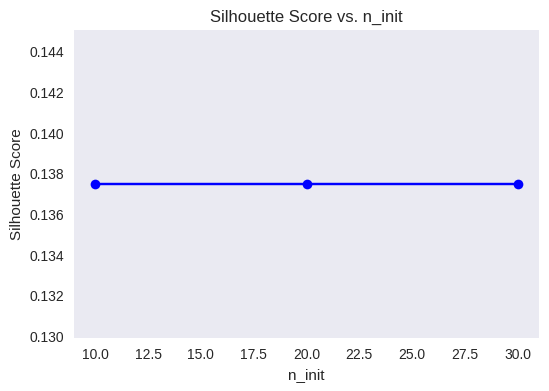

In [68]:
# Plot silhouette scores for different n_init values
plt.figure(figsize=(6, 4))
plt.plot(n_init_values, silhouette_scores_n_init, 'bo-')
plt.xlabel('n_init')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. n_init')
plt.grid(False)
plt.show()

In [75]:
# k-meansin en iyi tekaralama değeri yani n_init 20 
best_n_init = 20  
kmeans_tuned = KMeans(n_clusters=optimal_k, n_init=best_n_init, random_state=42)
cluster_labels_tuned = kmeans_tuned.fit_predict(scaled_df_tune)

In [76]:
# elde edilen küme bilgilerini cluster yani küme adı olarak ekler df_tune bizim df_copy den kopyaladığımız idi yani orijinal data_frame den , bu şekilde 
df_tune['Cluster'] = cluster_labels_tuned

In [77]:
print(df_tune.head()) # burda görüldüğü gibi cluster satırını ekledik

          Category          City        Country  Customer Name  Manufacturer  \
0  Office Supplies       Houston  United States  Darren Powers  Message Book   
1  Office Supplies    Naperville  United States  Phillina Ober         Avery   
2  Office Supplies    Naperville  United States  Phillina Ober         SAFCO   
3  Office Supplies    Naperville  United States  Phillina Ober           GBC   
4  Office Supplies  Philadelphia  United States     Mick Brown         Avery   

  Order Date        Order ID  Postal Code  \
0 2013-01-03  CA-2011-103800        77095   
1 2013-01-04  CA-2011-112326        60540   
2 2013-01-04  CA-2011-112326        60540   
3 2013-01-04  CA-2011-112326        60540   
4 2013-01-05  CA-2011-141817        19143   

                                        Product Name   Region  ... Quantity  \
0  Message Book, Wirebound, Four 5 1/2" X 4" Form...  Central  ...        2   
1                                          Avery 508  Central  ...        3   
2          

In [78]:
# en sonda kaç adet sınıfı sıralamaya göre gösterdik nesaka 0.sınıf da 2974 kisi varmıs
print("\nAyarlanmış Küme büyüklükleri:")
print(df_tune['Cluster'].value_counts())


Ayarlanmış Küme büyüklükleri:
Cluster
1    3965
3    2947
0    2044
2    1038
Name: count, dtype: int64


In [79]:
# Display first few rows with tuned cluster labels
print("\nDataFrame küme eklenmis sekilde olan gösterim (ilk 5 kisi):")
print(df_tune[['Customer Name', 'Recency_agg', 'Frequency', 'Monetary', 'Cluster']].head())


DataFrame küme eklenmis sekilde olan gösterim (ilk 5 kisi):
   Customer Name  Recency_agg  Frequency  Monetary  Cluster
0  Darren Powers          126         17  2.074234        1
1  Phillina Ober           86         10  2.074948        0
2  Phillina Ober           86         10  2.074948        0
3  Phillina Ober           86         10  2.074948        2
4     Mick Brown           44         10  2.112082        3


## Cluster Analysis and Interpretation

In [80]:
# df_tune ı analise etmek icin ayırıyoruz 
# df_tune daki tek değişiklik cluster(küme) eklendi ve kümelendi bu sekilde kümeler varken analiz yapacağız
df_analysis = df_tune

In [81]:
# SHer küme için özet istatistikler (RFM, Kar, İndirim)
cluster_summary = df_analysis.groupby('Cluster').agg({
    'Recency_agg': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max'],  #Not: Bu logaritmik dönüşümdür
    'Profit': ['mean', 'min', 'max'],
    'Discount': ['mean', 'min', 'max'],
    'Cluster': 'count'
}).round(2)

print("\nKüme Özeti İstatistikleri:")
print(cluster_summary)


Küme Özeti İstatistikleri:
        Recency_agg           Frequency         Monetary              Profit  \
               mean min   max      mean min max     mean   min   max    mean   
Cluster                                                                        
0            273.49   0  1165      9.25   1  22     2.06  1.03  2.33   20.46   
1             74.63   0   581     17.69   3  37     2.22  2.01  2.41   28.18   
2            103.33   0  1035     16.12   3  37     2.18  1.80  2.41 -103.81   
3             81.41   0   835     17.31   3  37     2.21  1.99  2.41   81.62   

                        Discount           Cluster  
            min     max     mean  min  max   count  
Cluster                                             
0        -538.0   945.0     0.11  0.0  0.8    2044  
1       -1049.0  1372.0     0.10  0.0  0.5    3965  
2       -6600.0     0.0     0.64  0.3  0.8    1038  
3        -183.0  8400.0     0.09  0.0  0.4    2947  


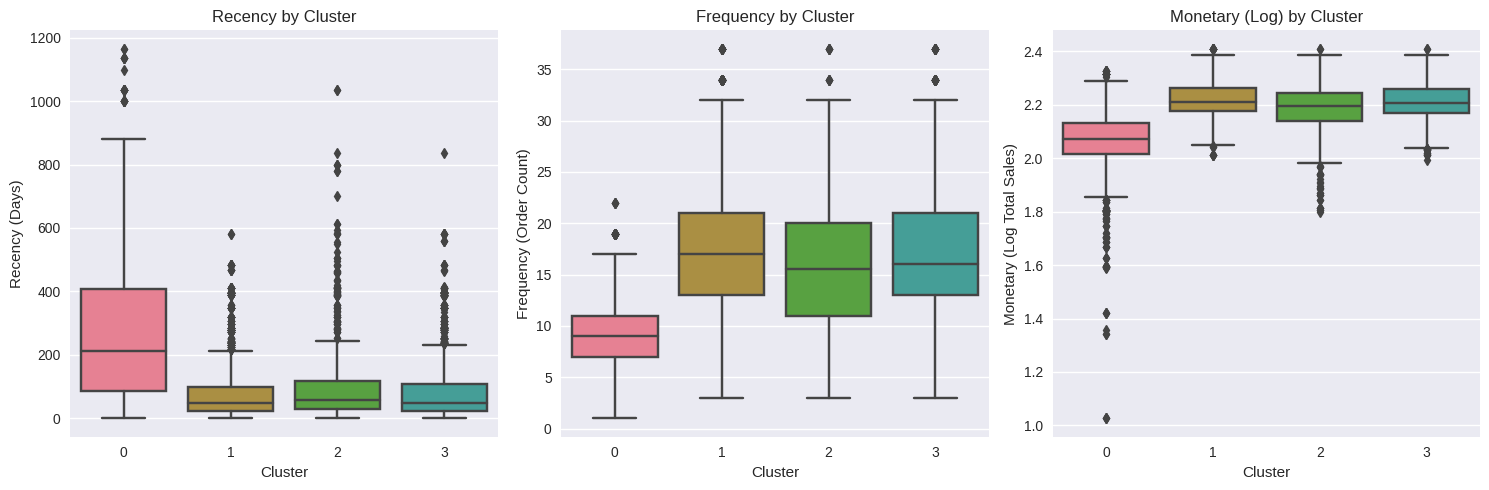

In [82]:
# Kümeler arasında RFM dağılımlarını görselleştirin
plt.figure(figsize=(15, 5))

# Recency
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency_agg', data=df_analysis)
plt.title('Kümeye Göre Güncellik')
plt.xlabel('küme')
plt.ylabel('güncellik (gün)')

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=df_analysis)
plt.title('Kümeye Göre Frekans')
plt.xlabel('küme')
plt.ylabel('sıklık (sayısı)')

# Monetary (log-transformed)
plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=df_analysis)
plt.title('Para (Log) Kümeleme bazında')
plt.xlabel('küme')
plt.ylabel('Parasal (Log Toplam Satışlar)')

plt.tight_layout()
plt.show()

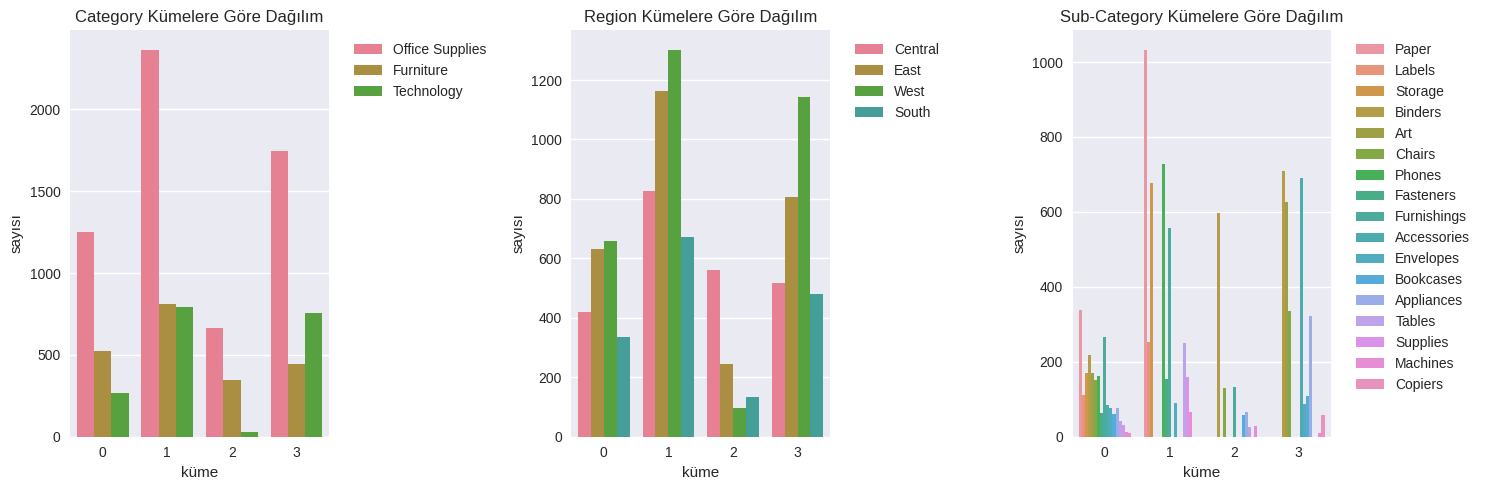

In [84]:
# Kümelere göre kategorik özellik dağılımları
categorical_features = ['Category', 'Region', 'Sub-Category']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df_analysis, x='Cluster', hue=feature)
    plt.title(f'{feature} Kümelere Göre Dağılım')
    plt.xlabel('küme')
    plt.ylabel('sayısı')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()